# Nested Cross-Validation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# fetch yahoo data
import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AMD'
start = '2014-01-01'
end = '2018-08-27'

# Read data 
dataset = yf.download(symbol,start,end)

# Only keep close columns 
dataset.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-01-02,3.95,3.95,3.98,3.84,3.85,20548400
2014-01-03,4.00,4.00,4.00,3.88,3.98,22887200
2014-01-06,4.13,4.13,4.18,3.99,4.01,42398300
2014-01-07,4.18,4.18,4.25,4.11,4.19,42932100
2014-01-08,4.18,4.18,4.26,4.14,4.23,30678700


In [3]:
dataset['Increase_Decrease'] = np.where(dataset['Volume'].shift(-1) > dataset['Volume'],1,0)
dataset['Buy_Sell_on_Open'] = np.where(dataset['Open'].shift(-1) > dataset['Open'],1,0)
dataset['Buy_Sell'] = np.where(dataset['Adj Close'].shift(-1) > dataset['Adj Close'],1,0)
dataset['Returns'] = dataset['Adj Close'].pct_change()
dataset = dataset.dropna()

In [4]:
dataset.tail()

,Adj Close,Close,High,Low,Open,Volume,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
Date,,,,,,,,,,
2018-08-20,19.980000,19.980000,20.08,19.350000,19.790001,62983200,0,1,1,0.010622
2018-08-21,20.400000,20.400000,20.42,19.860001,19.980000,55629000,1,1,1,0.021021
2018-08-22,20.900000,20.900000,20.92,20.209999,20.280001,62002700,1,1,1,0.024510
2018-08-23,22.290001,22.290001,22.32,21.139999,21.190001,113444100,1,1,1,0.066507
2018-08-24,23.980000,23.980000,24.00,22.670000,22.910000,164328200,0,0,0,0.075819


In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [6]:
NUM_TRIALS = 30
X = dataset.drop(['Buy_Sell'], axis=1)
Y = dataset['Buy_Sell']

In [7]:
p_grid = {"C": [1, 10, 100],
          "gamma": [.01, .1]}


In [8]:
svm = SVC(kernel="rbf")

In [9]:
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)


In [10]:
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    clf.fit(X, Y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=Y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

In [11]:
print("Average difference of {:6f} with std. dev. of {:6f}." .format(score_difference.mean(), score_difference.std()))

Average difference of 0.000228 with std. dev. of 0.000762.


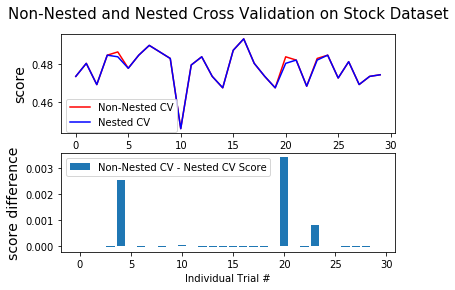

In [12]:
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on Stock Dataset",
          x=.5, y=1.1, fontsize="15")
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()